# PCA Analsysis? 

Idea: In order to get a relation between spatial and temporal patterns, try and do a PCA analysis for this goal

In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cm
#
from Calculations_Functions import proportions_from_filename, metrics_table
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
mask = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')

In [2]:
filename1 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112018_run_365_days_full_release_export_kernels_added.zarr'
filename2 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/RESTART_runs/PBDE_particles_for_0112018_run_365_days_full_release_export_kernels_added_restart_365_days_no_release_1_year.zarr'
#
filename3 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/PBDE_particles_for_0112022_run_365_days_full_release_run_tau_0_01_ratio_0_2_sv_5_AD_0_052.zarr'
filename4 = '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Simulations_runs/RESTART_runs/PBDE_particles_for_0112022_run_365_days_full_release_run_tau_0_01_ratio_0_2_sv_5_AD_0_052_restart_365_days_2nd_year_after_full_release.zarr'

In [3]:
vars_to_keep = ['trajectory', 'obs', 'lon', 'lat', 'z', 'time', 'status']
#
data = xr.open_dataset(filename1, engine = 'zarr', drop_variables=[v for v in xr.open_dataset(filename1, engine = 'zarr').variables if v not in vars_to_keep])
data2 = xr.open_dataset(filename2, engine = 'zarr', drop_variables=[v for v in xr.open_dataset(filename2, engine = 'zarr').variables if v not in vars_to_keep])
#
data3 = xr.open_dataset(filename3, engine = 'zarr', drop_variables=[v for v in xr.open_dataset(filename3, engine = 'zarr').variables if v not in vars_to_keep])
data4 = xr.open_dataset(filename4, engine = 'zarr', drop_variables=[v for v in xr.open_dataset(filename4, engine = 'zarr').variables if v not in vars_to_keep])

In [4]:
data_combined = xr.concat([data, data2], dim='obs' )

Sort and calculate particles amount through time to get both spatial and temporal dimensions

In [5]:
def particles_amount_map_by_depth_time(lons, lats, depths, times, depth_bins, mask = mask,
                                       num_lon=80, num_lat=80, time_freq="6H"):
    #
    # Flatten Parcels outputs
    lons = np.ravel(lons)
    lats = np.ravel(lats)
    depths = np.ravel(depths)
    times = pd.to_datetime(np.ravel(times))

    # Remove NaNs (deleted/missing particles)
    valid_mask = ~np.isnan(lons) & ~np.isnan(lats) & ~np.isnan(depths) & ~pd.isnull(times)
    lons, lats, depths, times = lons[valid_mask], lats[valid_mask], depths[valid_mask], times[valid_mask]

    # Create lon/lat bins
    longitudes = np.linspace(np.nanmin(mask['nav_lon']), np.nanmax(mask['nav_lon']), num_lon + 1)
    latitudes = np.linspace(np.nanmin(mask['nav_lat']), np.nanmax(mask['nav_lat']), num_lat + 1)

    # Assign indices
    lon_indices = np.digitize(lons, longitudes) - 1
    lat_indices = np.digitize(lats, latitudes) - 1

    # Keep only valid bins
    valid_mask = (
        (lon_indices >= 0) & (lon_indices < num_lon) &
        (lat_indices >= 0) & (lat_indices < num_lat)
    )
    lon_indices = lon_indices[valid_mask]
    lat_indices = lat_indices[valid_mask]
    depths = depths[valid_mask]
    times = times[valid_mask]

    # Bin times into 6-hour steps
    time_bins = pd.Series(times).dt.floor(time_freq)
    unique_times = pd.to_datetime(np.sort(time_bins.unique()))
    depth_labels = [f"{d0}-{d1} m" for d0, d1 in depth_bins]

    # Allocate output array
    out = np.zeros((len(unique_times), len(depth_bins), num_lat, num_lon), dtype=int)

    # Fill output
    for d_idx, (d0, d1) in enumerate(depth_bins):
        depth_mask = (depths >= d0) & (depths < d1)
        tvals = time_bins[depth_mask]
        lon_i = lon_indices[depth_mask]
        lat_i = lat_indices[depth_mask]

        for t_idx, t in enumerate(unique_times):
            mask_t = tvals == t
            if np.any(mask_t):
                flat_idx = np.ravel_multi_index((lat_i[mask_t], lon_i[mask_t]), dims=(num_lat, num_lon))
                counts = np.bincount(flat_idx, minlength=num_lat * num_lon).reshape((num_lat, num_lon))
                out[t_idx, d_idx, :, :] = counts

    # Wrap into xarray
    da = xr.DataArray(
        out,
        coords={
            "time": unique_times,
            "depth_bin": depth_labels,
            "lat": 0.5 * (latitudes[:-1] + latitudes[1:]),
            "lon": 0.5 * (longitudes[:-1] + longitudes[1:])
        },
        dims=("time", "depth_bin", "lat", "lon"),
        name="particle_counts"
    )

    return da


In [6]:
DATA = data3

In [7]:
lon_sed = DATA.where(DATA['status'] > 10)['lon'].values.flatten()        
lat_sed = DATA.where(DATA['status'] > 10)['lat'].values.flatten()
depth_sed = DATA.where(DATA['status'] > 10)['z'].values.flatten()
time_sed = DATA.where(DATA['status'] > 10)['time'].values.flatten()

#########
lon_wat = DATA.where((DATA['status'] > 0) & (DATA['status'] < 4))['lon'].values.flatten()
lat_wat = DATA.where((DATA['status'] > 0) & (DATA['status'] < 4))['lat'].values.flatten()
depth_wat = DATA.where((DATA['status'] > 0) & (DATA['status'] < 4))['z'].values.flatten()
time_wat = DATA.where((DATA['status'] > 0) & (DATA['status'] < 4))['time'].values.flatten()

In [8]:
depths_bins = [(0,50), (50,200), (200,400)]

In [9]:
amount_sediment = particles_amount_map_by_depth_time(lons=lon_sed, lats=lat_sed, depths = depth_sed, times = time_sed, depth_bins = depths_bins)
amount_water = particles_amount_map_by_depth_time(lons=lon_wat, lats=lat_wat, depths = depth_wat, times = time_wat, depth_bins = depths_bins)

/tmp/ipykernel_2930859/2370776031.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_bins = pd.Series(times).dt.floor(time_freq)
/tmp/ipykernel_2930859/2370776031.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_bins = pd.Series(times).dt.floor(time_freq)


In [10]:
def finder2(target_lat, target_lon,mask=mask):
# Load grid data (e.g., from a NetCDF file)
    lat = mask.nav_lat
    lon = mask.nav_lon
    #find closest grid
    distance = ((lat - target_lat)**2 + (lon - target_lon)**2)**0.5
    nearest_index = distance.argmin()
    return int(nearest_index // lon.shape[1]), int(nearest_index % lon.shape[1])

In [11]:
X_water = np.zeros_like(amount_water.lon)
Y_water = np.zeros_like(amount_water.lat)
for i in range(len(X_water)):
    for j in range(len(Y_water)):
        jjj,iii = finder2(amount_water.lat[j], amount_water.lon[i])
        X_water[i]=iii
        Y_water[j]=jjj
#########################
X_sediment = np.zeros_like(amount_sediment.lon)
Y_sediment = np.zeros_like(amount_sediment.lat)
for i in range(len(X_sediment)):
    for j in range(len(Y_sediment)):
        jjj,iii = finder2(amount_sediment.lat[j], amount_sediment.lon[i])
        X_sediment[i]=iii
        Y_sediment[j]=jjj        

In [12]:
amount_water_XY = amount_water.rename({'lon': 'X', 'lat': 'Y'})
amount_water_XY = amount_water_XY.assign_coords({
    'X': X_water,
    'Y': Y_water})
#
amount_sediment_XY = amount_sediment.rename({'lon': 'X', 'lat': 'Y'})
amount_sediment_XY = amount_sediment_XY.assign_coords({
    'X': X_sediment,
    'Y': Y_sediment})

PCA

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#
def run_pca(da, depth_bin, n_components=4):
    #
    # Select depth
    da_sub = da.sel(depth_bin=depth_bin)

    # Flatten spatial dims
    # X = da_sub.stack(features=("Y", "X")).values
    X = da_sub.stack(features=("lat", "lon")).values

    # Standardize
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_std)

    eigvecs = pca.components_
    fracVar = pca.explained_variance_ratio_

    return X_pca, pca, eigvecs, fracVar


In [14]:
X_pca_water_surface, pca_water_surface, eigvecs_water_surface, fracVar_water_surface = run_pca(amount_water, "0-50 m", n_components=2)
X_pca_sediment_surface, pca_sediment_surface, eigvecs_sediment_surface, fracVar_sediment_surface = run_pca(amount_sediment, "0-50 m", n_components=2)

In [15]:
X_pca_water_intermediate, pca_water_intermediate, eigvecs_water_intermediate, fracVar_water_intermediate = run_pca(amount_water, "50-200 m", n_components=2)
X_pca_sediment_intermediate, pca_sediment_intermediate, eigvecs_sediment_intermediate, fracVar_sediment_intermediate = run_pca(amount_sediment, "50-200 m", n_components=2)

In [16]:
X_pca_water_bottom, pca_water_bottom, eigvecs_water_bottom, fracVar_water_bottom = run_pca(amount_water, "200-400 m", n_components=2)
X_pca_sediment_bottom, pca_sediment_bottom, eigvecs_sediment_bottom, fracVar_sediment_bottom = run_pca(amount_sediment, "200-400 m", n_components=2)

Finder of GridX and GridY to plot particles in Model Grid

In [17]:
# Model has a rotation of 29 degrees

In [20]:
def plot_pca_water_sediment(data_w_d, X_pca_water_sediment, pca_water_sediment, depth_bin, n, frac_water_sediment):
    from matplotlib.colors import ListedColormap
    plt.rcParams.update({'font.size': 14})
    colors = [(0, 0, 0, 1),  # Black for land (1)
              (0, 0, 0, 0)]  # Transparent for water (0)
    cmap = ListedColormap(colors)

    da_water = data_w_d[0].sel(depth_bin=depth_bin)
    da_sediment = data_w_d[1].sel(depth_bin=depth_bin)
    #
    n_lat_water = len(da_water.lat)
    n_lon_water = len(da_water.lon)
    #
    n_lat_sediment = len(da_sediment.lat)
    n_lon_sediment = len(da_sediment.lon)
    #
    loadings_water = pca_water_sediment[0].components_.reshape(-1, n_lat_water, n_lon_water)
    loadings_sediment = pca_water_sediment[1].components_.reshape(-1, n_lat_sediment, n_lon_sediment)


    # Create figure and axes grid (n rows, 2 cols)
    fig, ax = plt.subplots(n, 3, figsize=(20, 6 * n), gridspec_kw={"width_ratios": [2, 1, 1]})

    for kk in range(n):
        # Time series (principal component)
        ax[kk, 0].plot(da_water.time, X_pca_water_sediment[0][:, kk], '-k', linewidth=1, label = 'Water Column')
        ax[kk, 0].plot(da_sediment.time, X_pca_water_sediment[1][:, kk], color='tab:brown', linewidth=1, label = 'Sediment')    
        ax[kk, 0].set_title(f"Amount of Particles ({depth_bin})")
        ax[kk, 0].set_ylabel(f"Score of PC #{kk+1}")

        ax[kk, 0].tick_params(axis='x', rotation=45)
        ax[kk, 0].hlines(y = 0, xmin =da_water.time[0], xmax =da_water.time[-1], color = 'g', linestyle = '--', alpha = .7)
        ax[kk, 0].legend(loc = 'upper left')
        #
        # Spatial pattern (eigenvector)
        cc1 = ax[kk, 1].pcolormesh(da_water.lon, da_water.lat, loadings_water[kk, :, :],
                                  cmap='bwr', shading='auto')
        ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
        ax[kk, 1].set_title(f"Spatial Pattern (#{kk+1}) ({depth_bin}) \n Variance Explained: {np.round(frac_water_sediment[0][kk] * 100)} %")
        ax[kk, 1].set_xlabel("Longitude")
        ax[kk, 1].set_ylabel("Latitude")
        fig.colorbar(cc1, ax=ax[kk, 1], label="Loading Water Column")
        cc1.set_clim(-0.1, 0.1)
        #
        cc2 = ax[kk, 2].pcolormesh(da_sediment.lon, da_sediment.lat, loadings_sediment[kk, :, :],
                                  cmap='bwr', shading='auto')
        ax[kk,2].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
        ax[kk, 2].set_title(f"Spatial Pattern (#{kk+1}) ({depth_bin}) \n Variance Explained: {np.round(frac_water_sediment[1][kk] * 100)} %", color = 'tab:brown')
        ax[kk, 2].set_xlabel("Longitude")
        ax[kk, 2].set_ylabel("Latitude")    
        #
        fig.colorbar(cc2, ax=ax[kk, 2], label="Loading Sediment")
        cc2.set_clim(-0.1, 0.1)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2930859/1885195027.py:38: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2930859/1885195027.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,2].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


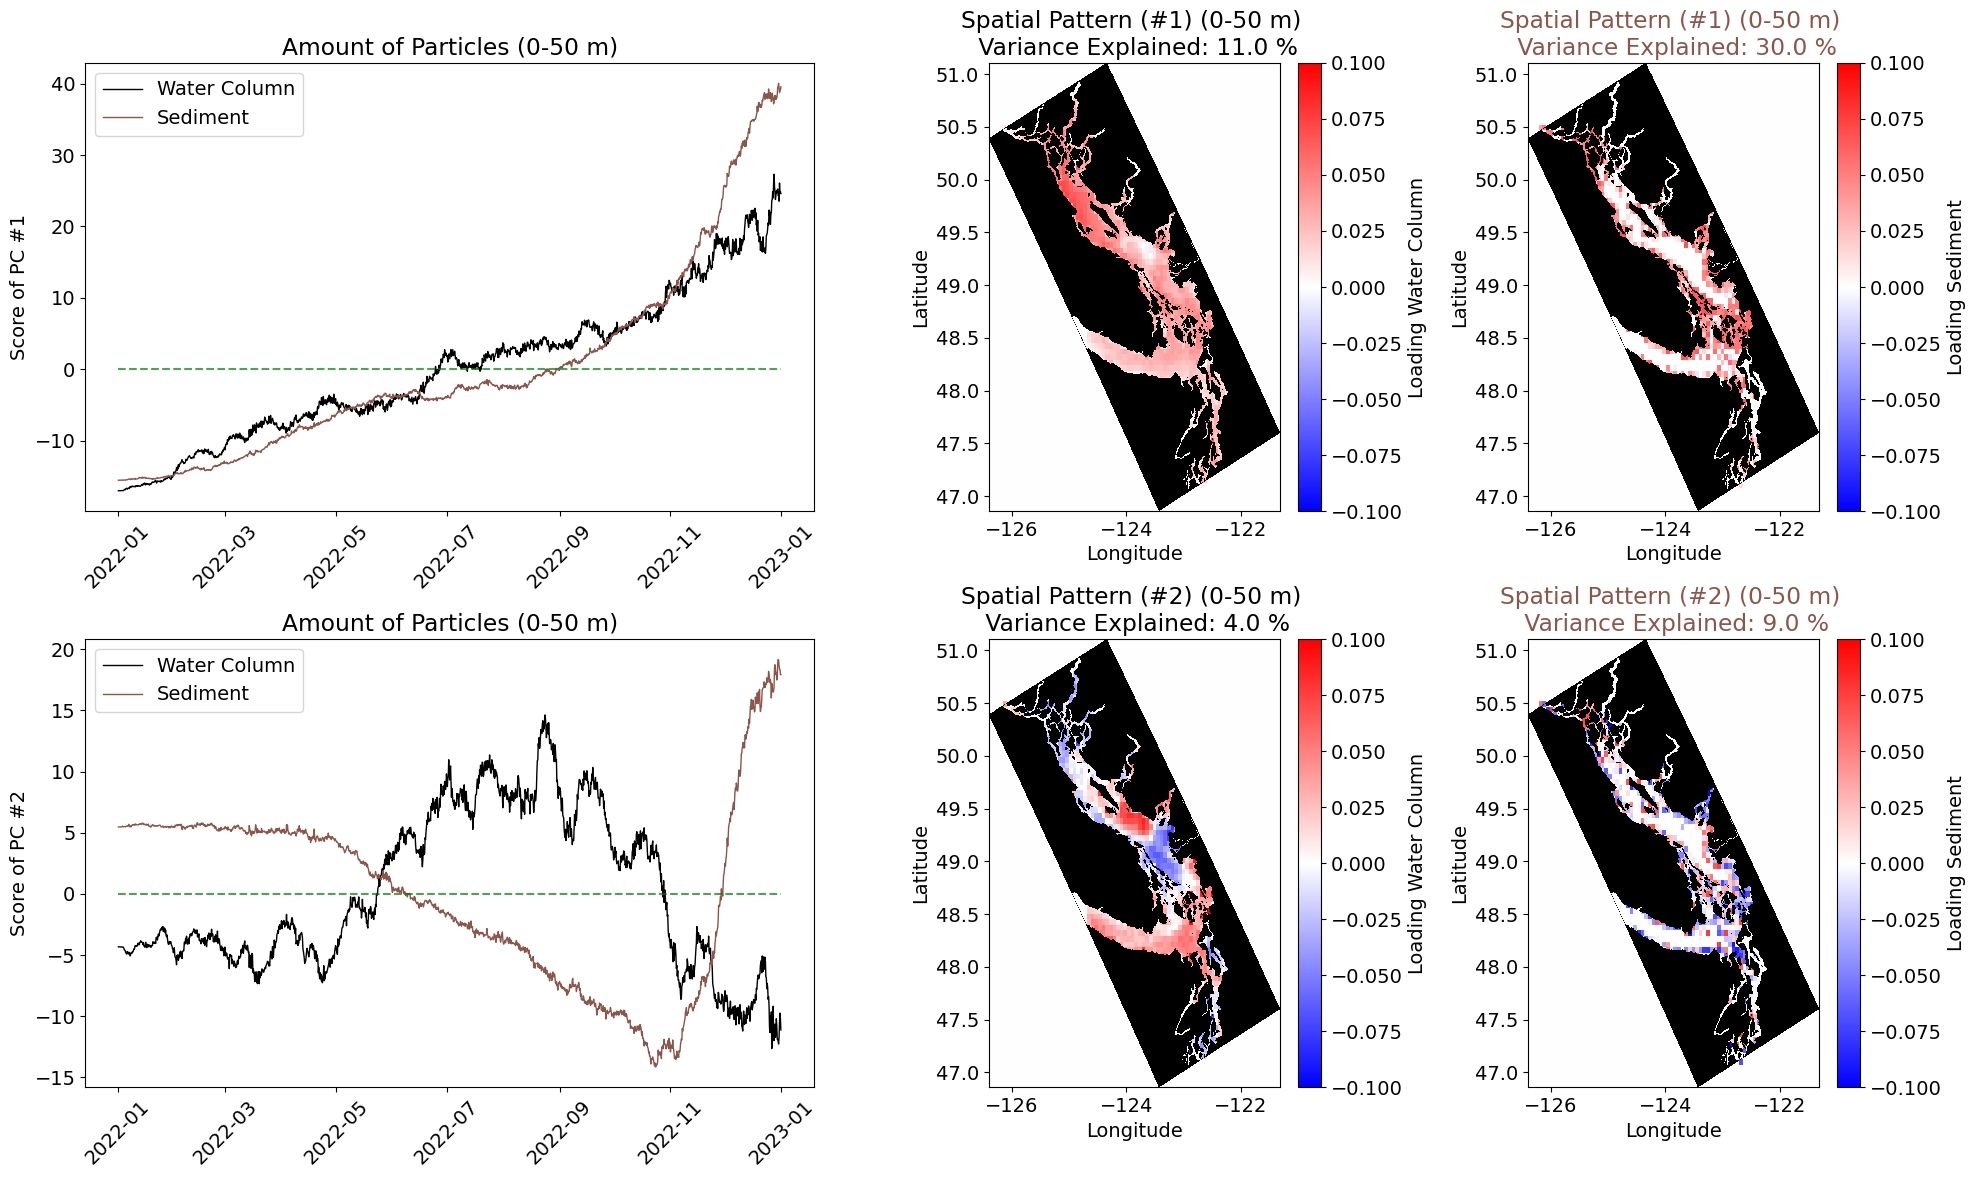

In [21]:
plot_pca_water_sediment([amount_water, amount_sediment], [X_pca_water_surface, X_pca_sediment_surface], [pca_water_surface,pca_sediment_surface], depth_bin="0-50 m", n=2, frac_water_sediment=[fracVar_water_surface, fracVar_sediment_surface])

/tmp/ipykernel_2930859/1885195027.py:38: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2930859/1885195027.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,2].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


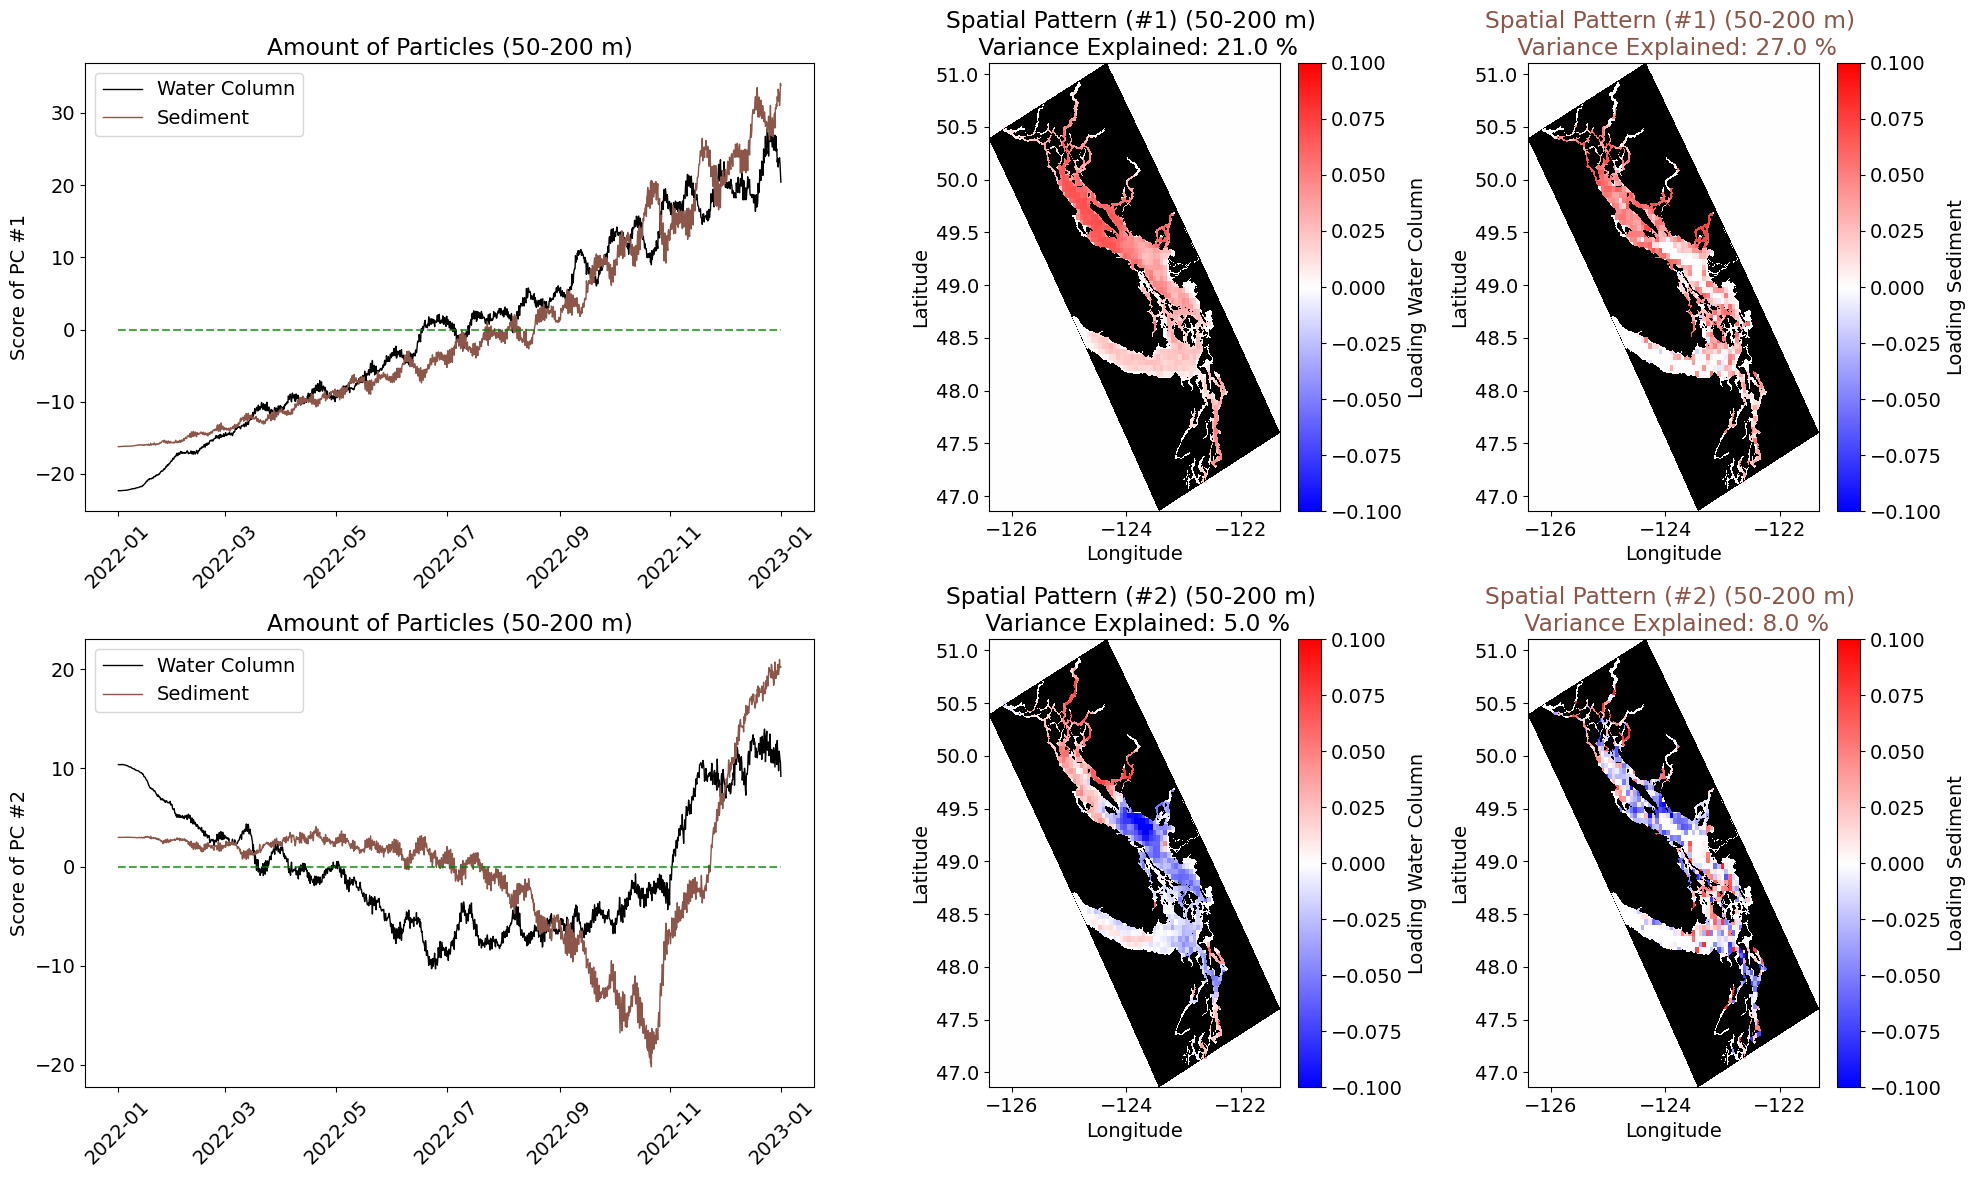

In [22]:
plot_pca_water_sediment([amount_water, amount_sediment], [X_pca_water_intermediate, X_pca_sediment_intermediate], [pca_water_intermediate,pca_sediment_intermediate], depth_bin="50-200 m", n=2, frac_water_sediment=[fracVar_water_intermediate, fracVar_sediment_intermediate])

/tmp/ipykernel_2930859/1885195027.py:38: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
/tmp/ipykernel_2930859/1885195027.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,2].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


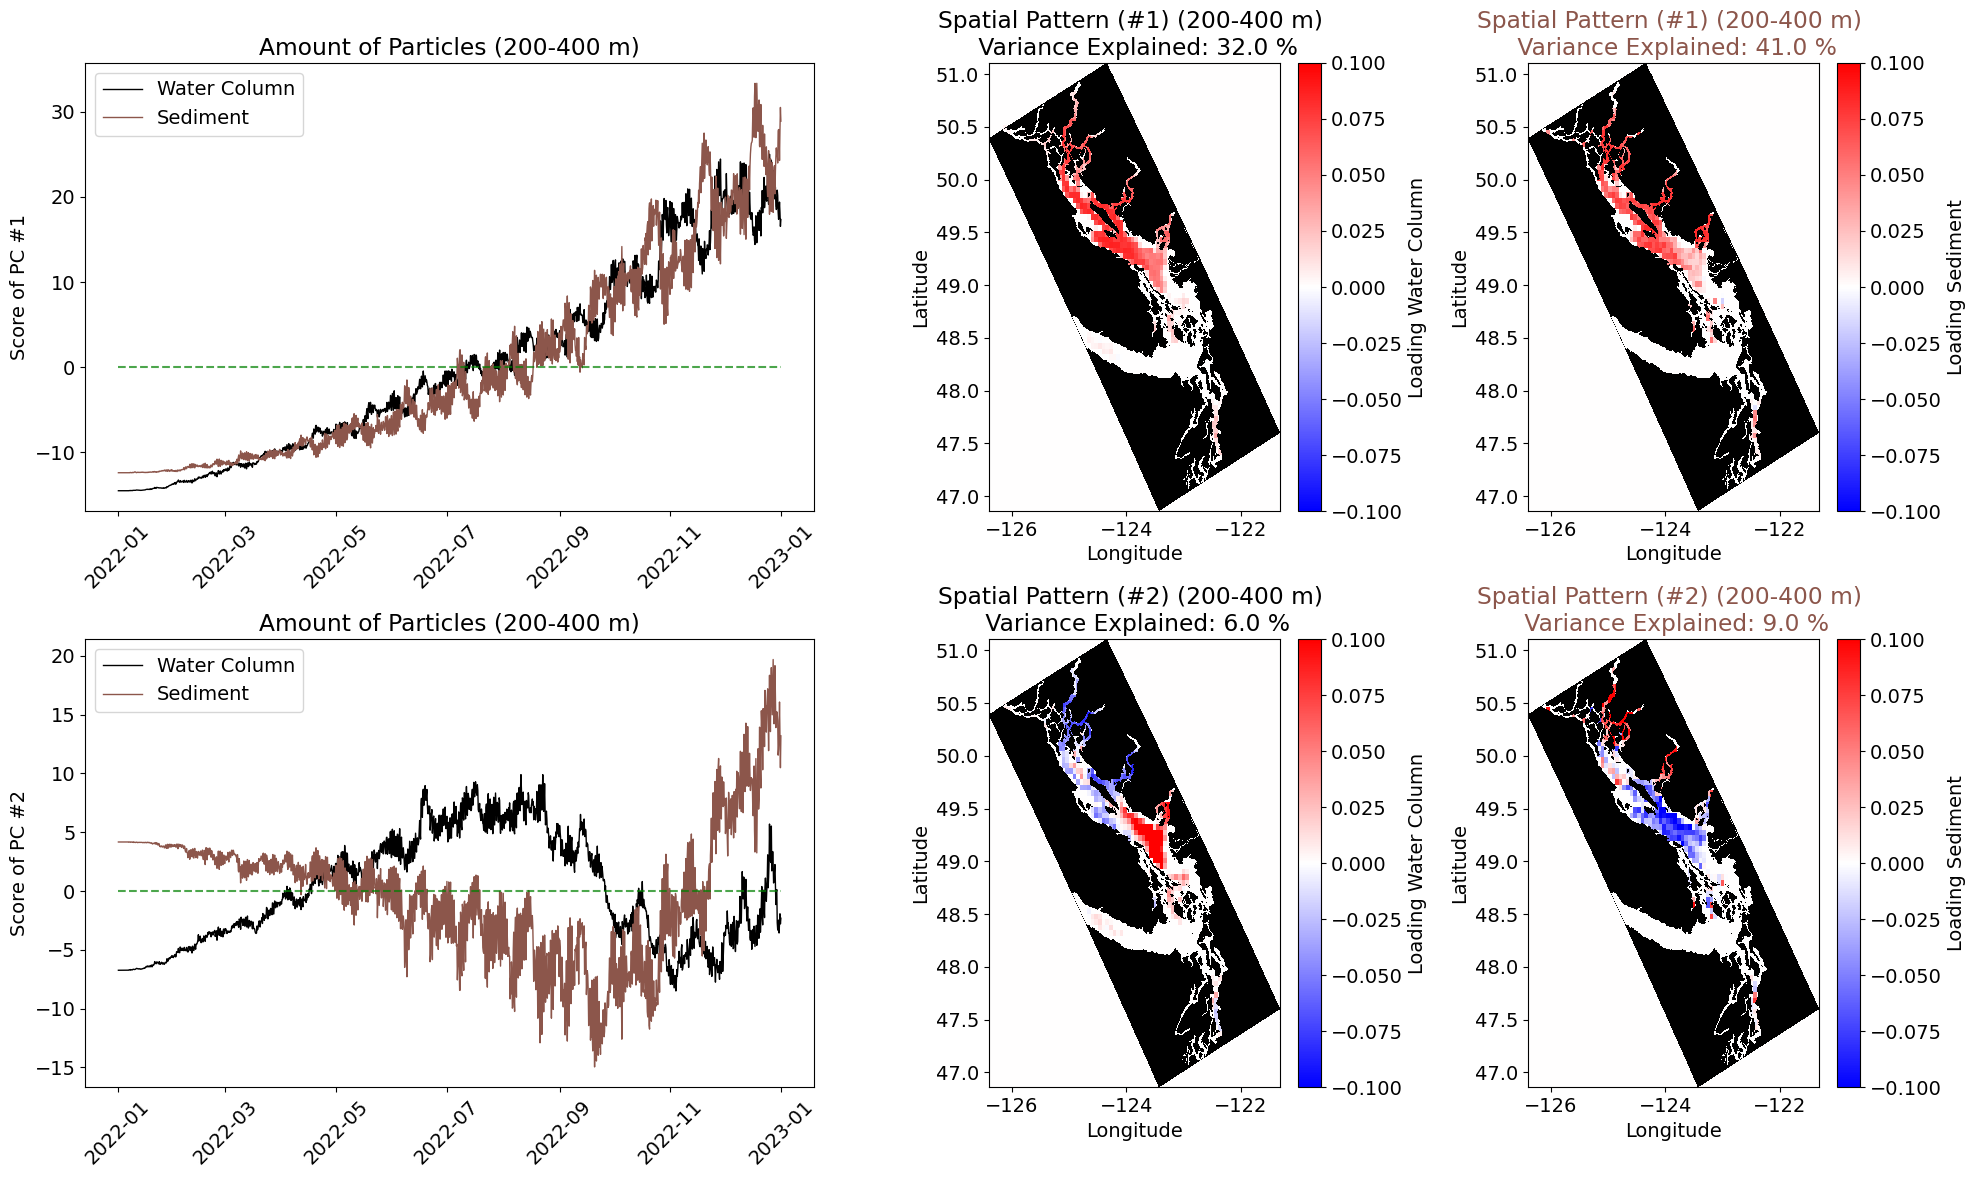

In [23]:
plot_pca_water_sediment([amount_water, amount_sediment], [X_pca_water_bottom, X_pca_sediment_bottom], [pca_water_bottom,pca_sediment_bottom], depth_bin="200-400 m", n=2, frac_water_sediment=[fracVar_water_bottom, fracVar_sediment_bottom])

Some conclusions:

- Resuspension signal with transitions from sediment-watercolumn and vice versa are the main patterns with more variance of the system explained, being a consistent signal between the two different main components.

- Seasonal patterns are captured clearly for surface and intermediate waters, but with low percentage of the variance explained

In [24]:
def plot_pca_results(da, X_pca, pca, depth_bin, n, name, frac):
    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    colors = [(0, 0, 0, 1),  # Black for land (1)
              (0, 0, 0, 0)]  # Transparent for water (0)
    cmap = ListedColormap(colors)
    
    da_sub = da.sel(depth_bin=depth_bin)

    n_lat = len(da_sub.lat)
    n_lon = len(da_sub.lon)
    #
    loadings = pca.components_.reshape(-1, n_lat, n_lon)

    # Create figure and axes grid (n rows, 2 cols)
    fig, ax = plt.subplots(n, 2, figsize=(15, 5 * n))

    for kk in range(n):
        # Time series (principal component)
        ax[kk, 0].plot(da_sub.time, X_pca[:, kk], '-k', linewidth=2)
        ax[kk, 0].set_title(f"Amount of Particles in the {name} ({depth_bin}) - Variance Explained: {np.round(frac[kk] * 100)} %")
        ax[kk, 0].set_ylabel(f"Score of PC #{kk+1}")

        ax[kk, 0].tick_params(axis='x', rotation=45)
        ax[kk, 0].hlines(y = 0, xmin =da_sub.time[0], xmax =da_sub.time[-1], color = 'g', linestyle = '--', alpha = .7)

        # Spatial pattern (eigenvector)
        cc = ax[kk, 1].pcolormesh(da_sub.lon, da_sub.lat, loadings[kk, :, :],
                                  cmap='bwr', shading='auto')
        ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)
        ax[kk, 1].set_title(f"Spatial Pattern (Eigenvector #{kk+1}) ({depth_bin})")
        ax[kk, 1].set_xlabel("Longitude")
        ax[kk, 1].set_ylabel("Latitude")
        #
        fig.colorbar(cc, ax=ax[kk, 1], label="Loading")
        cc.set_clim(-0.1, 0.1)

    plt.tight_layout()
    plt.show()

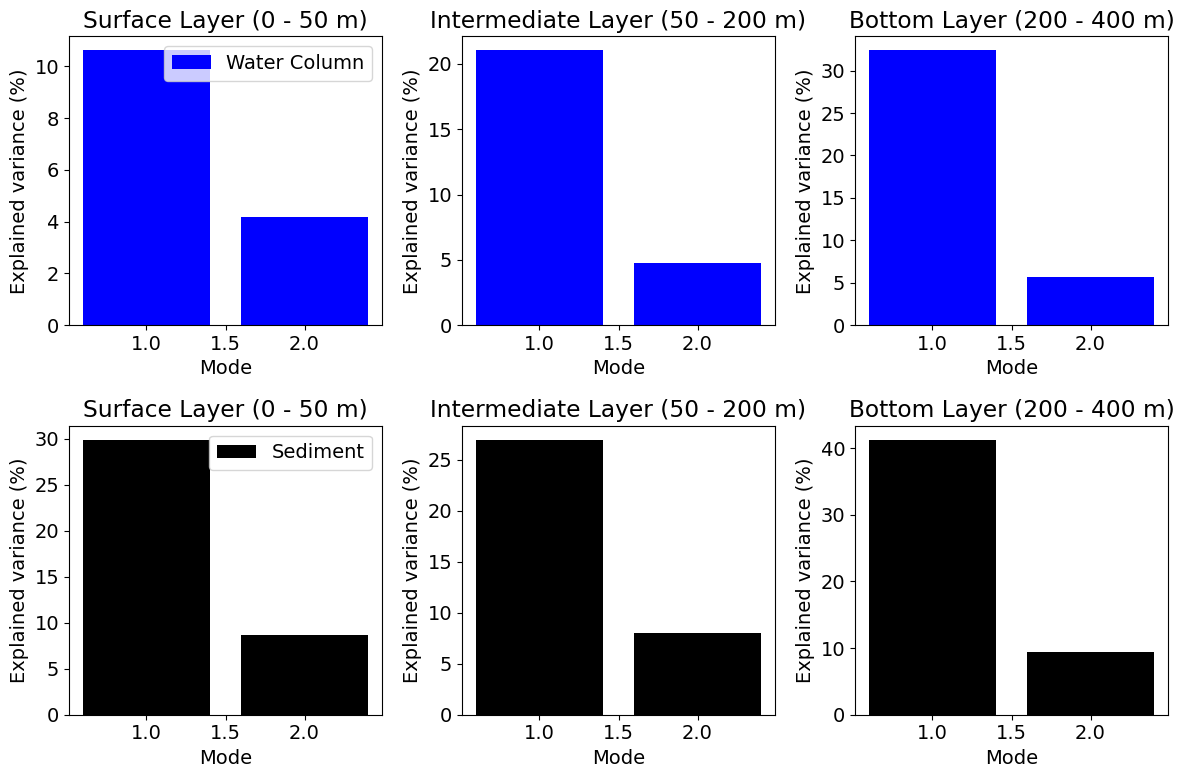

In [25]:
fig, ax = plt.subplots(2,3, figsize=(12,8))
ax[0,0].bar(np.arange(1, len(fracVar_water_surface)+1), fracVar_water_surface*100, color = 'b',  label = 'Water Column')
ax[0,0].set_xlabel('Mode')
ax[0,0].set_ylabel('Explained variance (%)')
ax[0,0].set_title('Surface Layer (0 - 50 m)')
ax[0,0].legend()
#
ax[0,1].bar(np.arange(1, len(fracVar_water_intermediate)+1), fracVar_water_intermediate*100, color = 'b', label = 'Water Column')
ax[0,1].set_xlabel('Mode')
ax[0,1].set_ylabel('Explained variance (%)')
ax[0,1].set_title('Intermediate Layer (50 - 200 m)')
#
ax[0,2].bar(np.arange(1, len(fracVar_water_bottom)+1), fracVar_water_bottom*100, color = 'b', label = 'Water Column')
ax[0,2].set_xlabel('Mode')
ax[0,2].set_ylabel('Explained variance (%)')
ax[0,2].set_title('Bottom Layer (200 - 400 m)')
#
ax[1,0].bar(np.arange(1, len(fracVar_sediment_surface)+1), fracVar_sediment_surface*100, color = 'k',  label = 'Sediment')
ax[1,0].set_xlabel('Mode')
ax[1,0].set_ylabel('Explained variance (%)')
ax[1,0].set_title('Surface Layer (0 - 50 m)')
ax[1,0].legend()
#
ax[1,1].bar(np.arange(1, len(fracVar_sediment_intermediate)+1), fracVar_sediment_intermediate*100, color = 'k', label = 'Sediment')
ax[1,1].set_xlabel('Mode')
ax[1,1].set_ylabel('Explained variance (%)')
ax[1,1].set_title('Intermediate Layer (50 - 200 m)')
#
ax[1,2].bar(np.arange(1, len(fracVar_sediment_bottom)+1), fracVar_sediment_bottom*100, color = 'k', label = 'Sediment')
ax[1,2].set_xlabel('Mode')
ax[1,2].set_ylabel('Explained variance (%)')
ax[1,2].set_title('Bottom Layer (200 - 400 m)')
#
plt.tight_layout()

# Surface - Intermediate - Bottom Layers in the Water Column

/tmp/ipykernel_2930859/1923899811.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


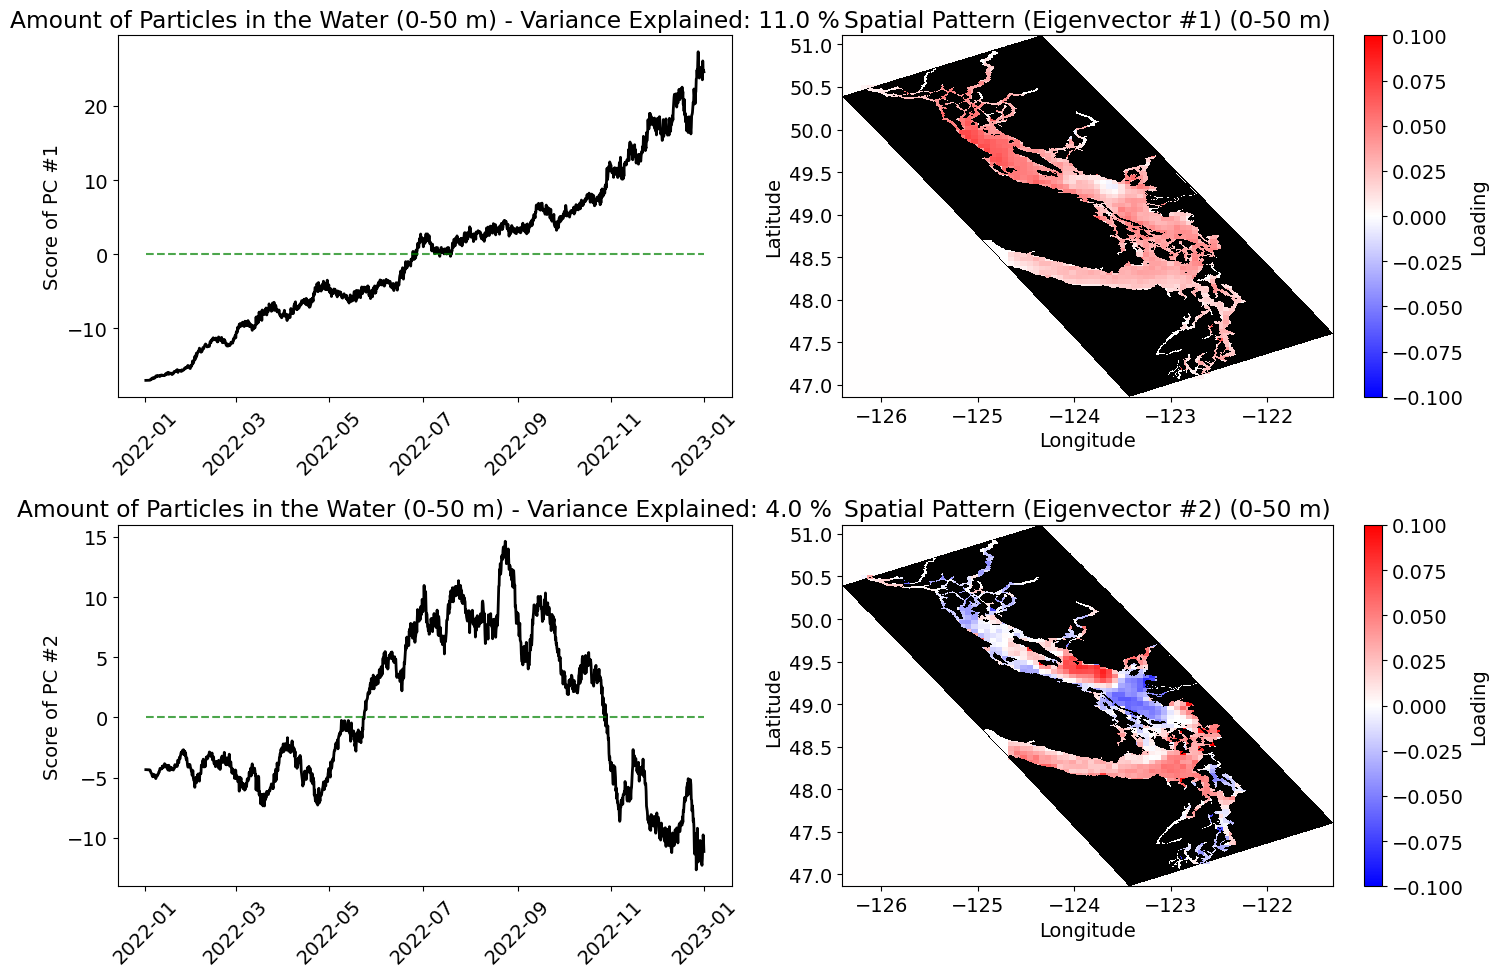

In [26]:
plot_pca_results(amount_water, X_pca_water_surface, pca_water_surface, depth_bin="0-50 m", n=2, name= 'Water', frac = fracVar_water_surface)

/tmp/ipykernel_2930859/1923899811.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


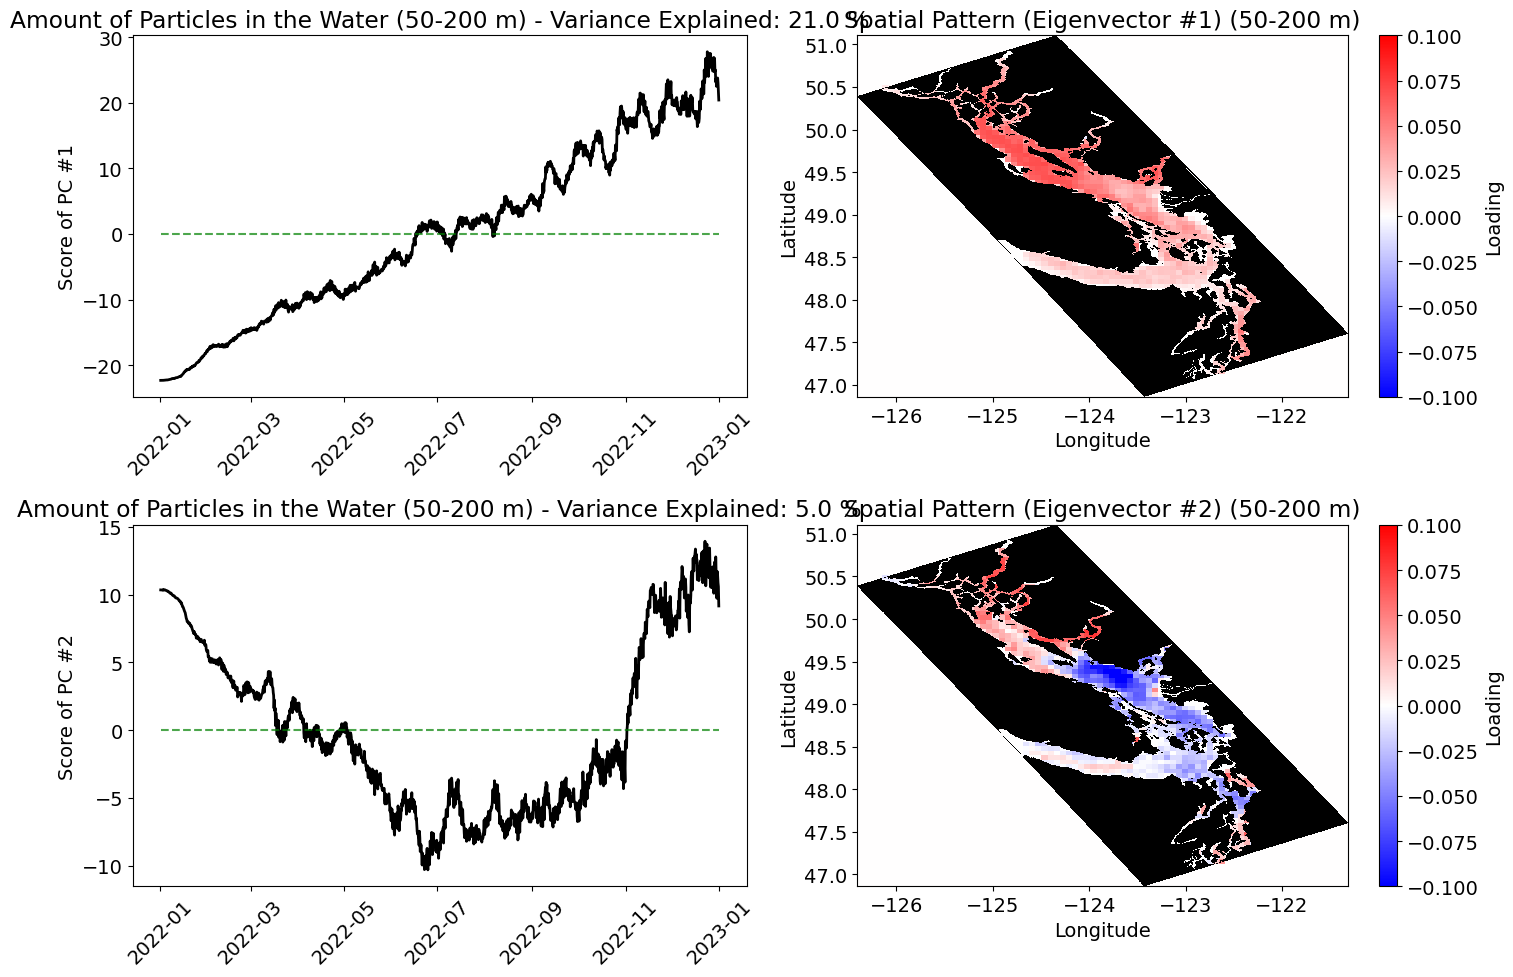

In [27]:
plot_pca_results(amount_water, X_pca_water_intermediate, pca_water_intermediate, depth_bin="50-200 m", n=2, name= 'Water', frac = fracVar_water_intermediate)

/tmp/ipykernel_2930859/1923899811.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


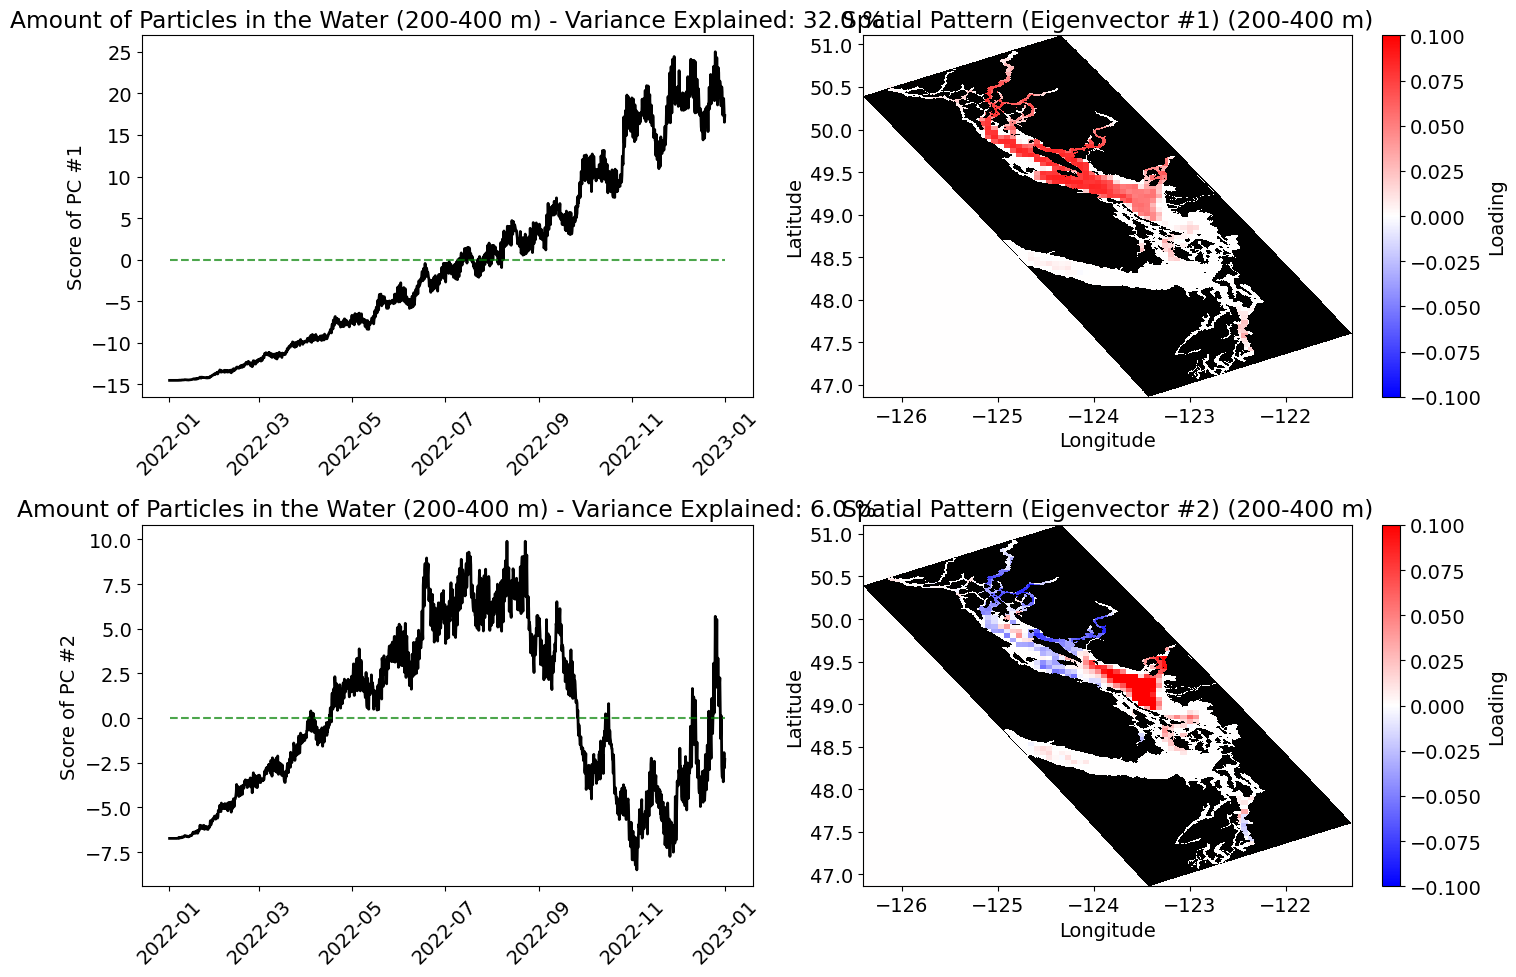

In [28]:
plot_pca_results(amount_water, X_pca_water_bottom, pca_water_bottom, depth_bin="200-400 m", n=2, name= 'Water', frac = fracVar_water_bottom)

# Surface - Intermediate - Bottom Layers in the Sediment

/tmp/ipykernel_2930859/1923899811.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


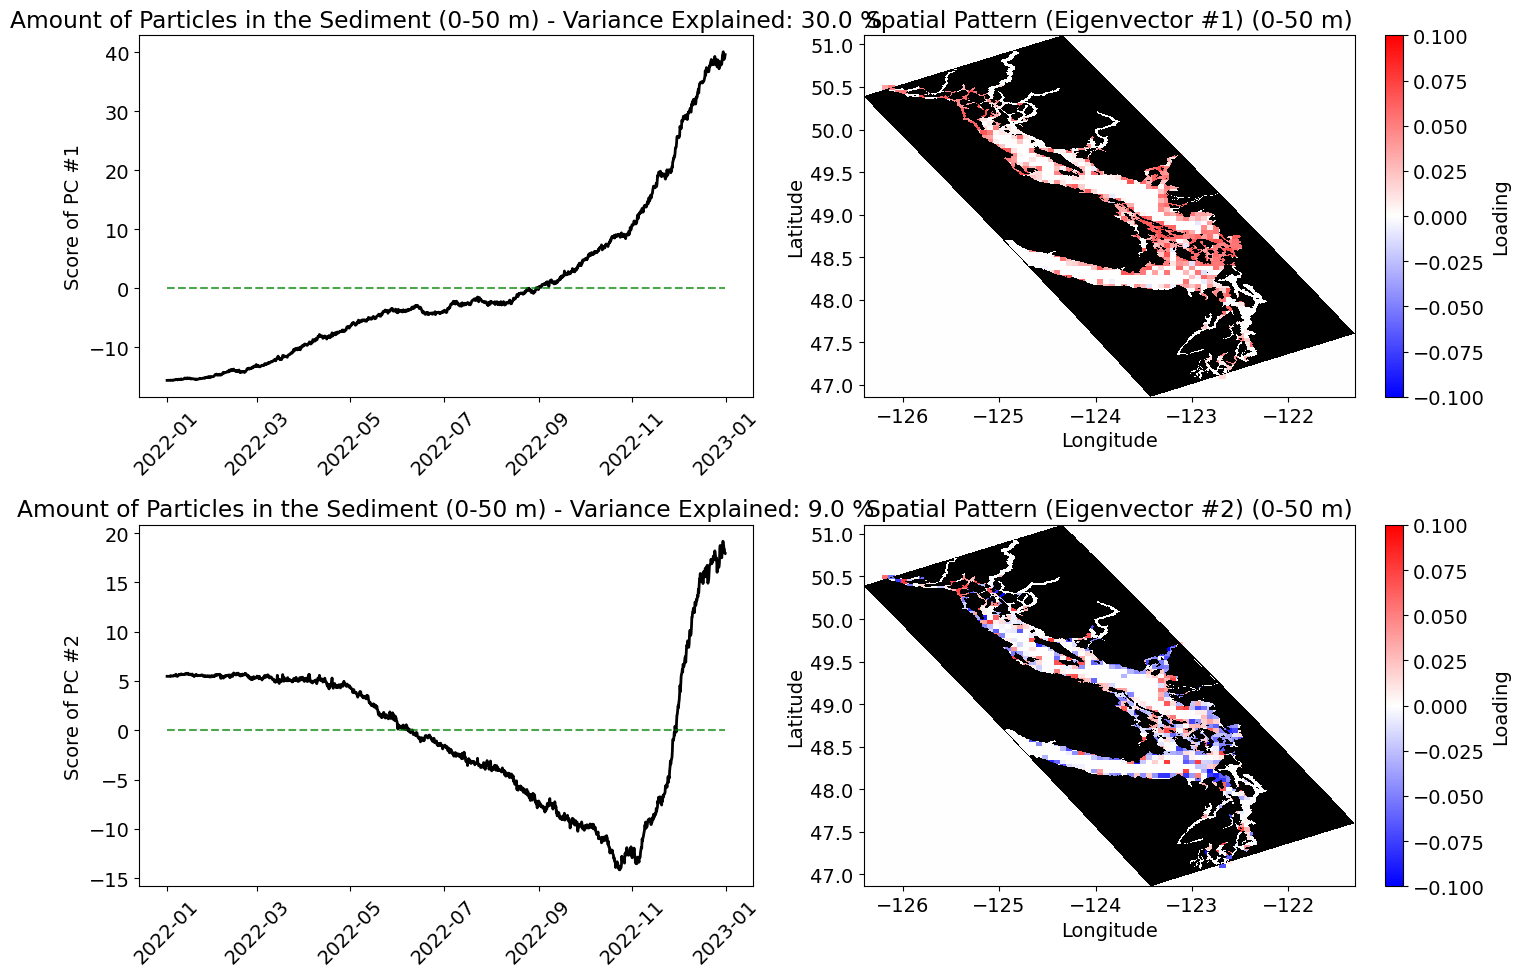

In [29]:
plot_pca_results(amount_sediment, X_pca_sediment_surface, pca_sediment_surface, depth_bin="0-50 m", n=2, name= 'Sediment', frac = fracVar_sediment_surface)

/tmp/ipykernel_2930859/1923899811.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


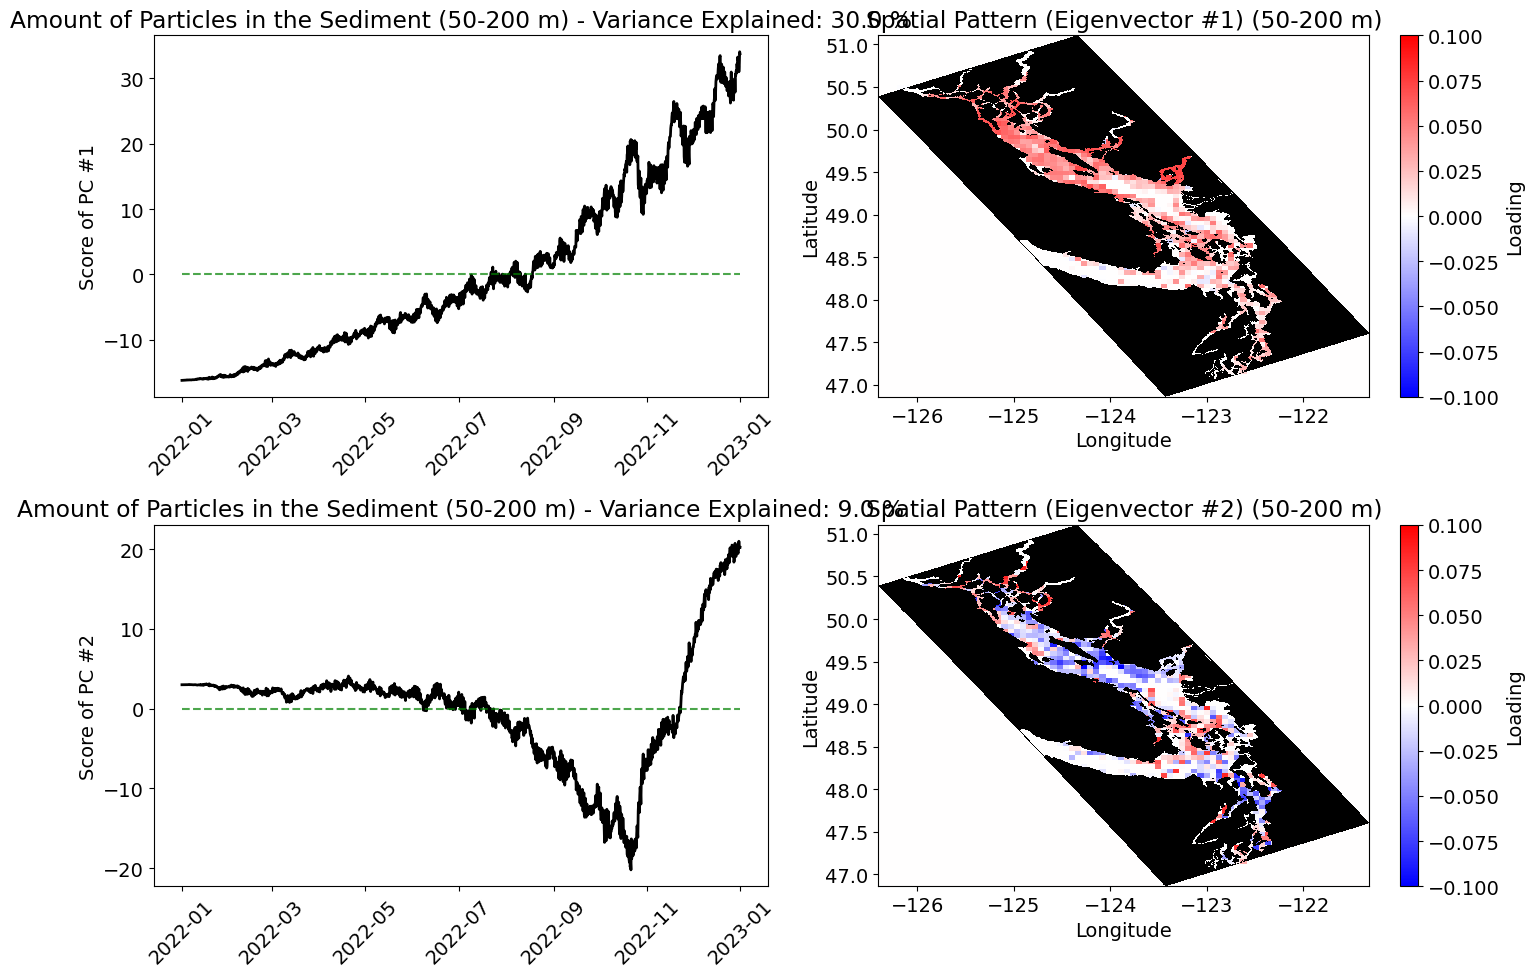

In [30]:
plot_pca_results(amount_sediment, X_pca_sediment_intermediate, pca_sediment_intermediate, depth_bin="50-200 m", n=2, name= 'Sediment', frac = fracVar_sediment_surface)

/tmp/ipykernel_2930859/1923899811.py:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[kk,1].pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0][0], cmap = cmap)


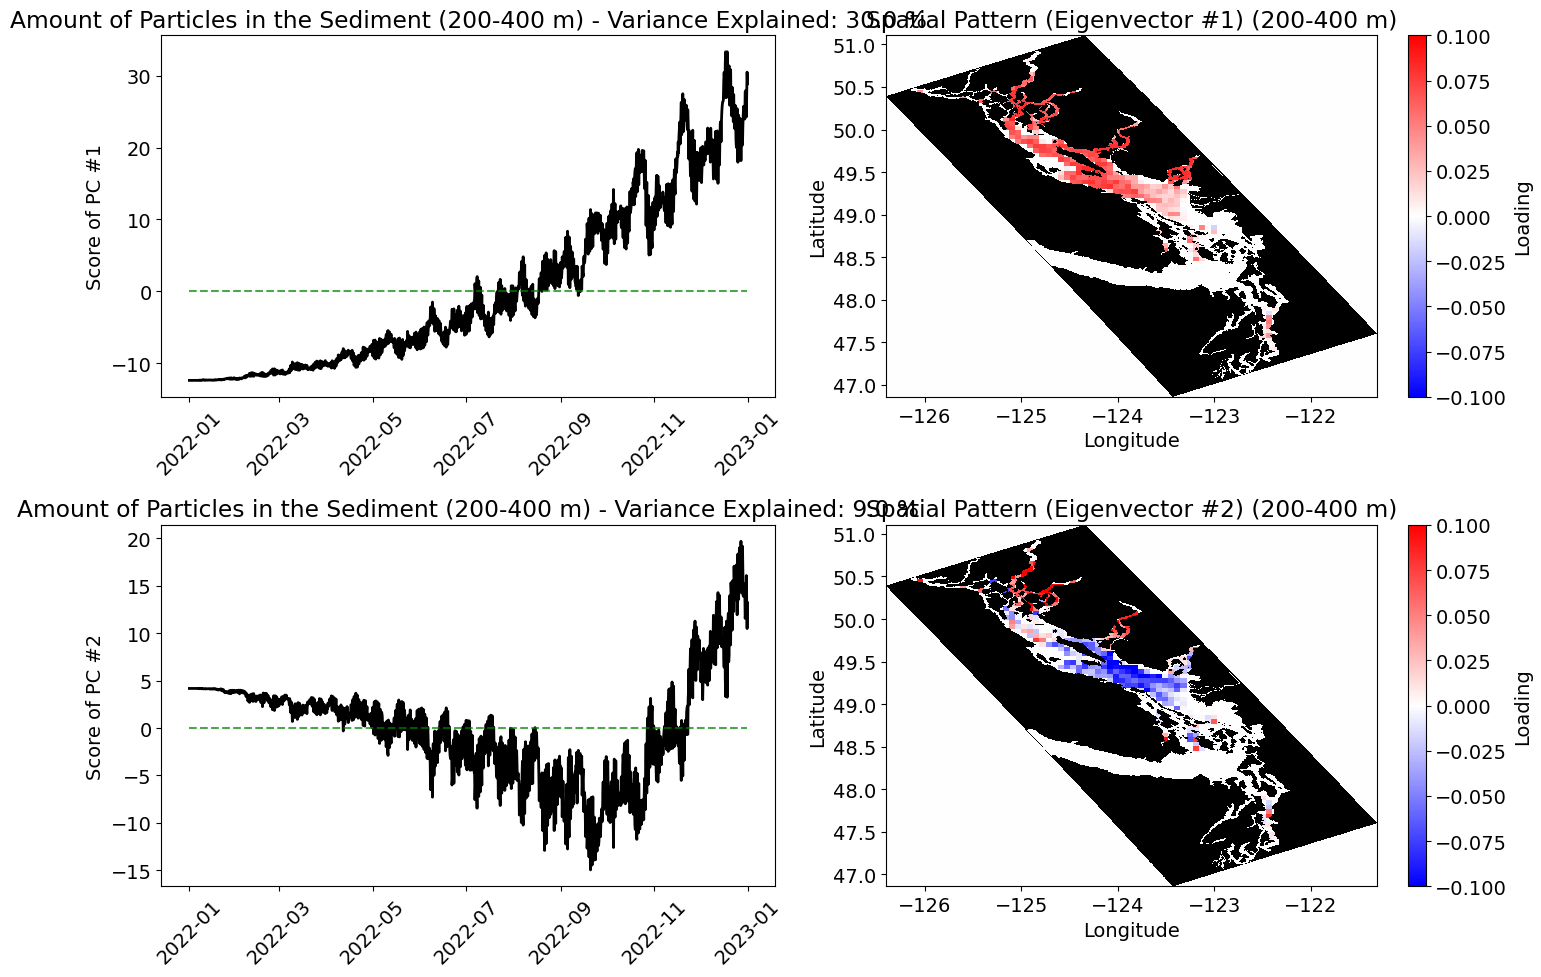

In [31]:
plot_pca_results(amount_sediment, X_pca_sediment_bottom, pca_sediment_bottom, depth_bin="200-400 m", n=2, name= 'Sediment', frac = fracVar_sediment_surface)